In [1]:
import numpy as np
import pandas as pd 
import plotly.express as px

import shap
from more_itertools import windowed
from tqdm.notebook import tqdm
import ipywidgets as widgets
widgets.IntSlider()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import lightgbm as lgb

from pyomo.environ import *
from pyomo import *

import optuna
from optuna.integration import LightGBMPruningCallback

pd.set_option('display.max_rows', 50)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def convert_to_multiindex(df):
    df = df.groupby(level=0).apply(lambda x: x.set_index('date').resample('1M').last())
    df = df.reset_index()
    df = df.set_index(['date','ticker']).sort_index()
    return df

def rolling_returns(df, roll_list, col_list):
    temp = pd.DataFrame(index=df.index)
    with tqdm(total=len(col_list)*len(roll_list)) as pbar:
        for col in col_list:
            for roll in roll_list:
                roll_col_name = f'rolling_{col}_{roll}M'
                rolled_col = df[col].unstack().pct_change(roll).stack()
                temp[roll_col_name] = rolled_col
                pbar.update(1)

    longest_roll = max(roll_list)           
    mask = df.index.get_level_values(0).unique()[longest_roll]        
    temp = temp.loc[mask:]  
    df = df.join(temp, how = 'right')
    return df

# Sharadar Data

In [3]:
%%time
financials_raw = pd.read_csv('data/financials.csv', parse_dates=['date'])
sec_master_raw = pd.read_csv('data/sec_master.csv')
sep_raw = pd.read_csv('data/sep.csv', parse_dates=['date'])
sf1_raw = pd.read_csv('data/sf1.csv', parse_dates=['calendardate'])
sp500_constituents_raw = pd.read_csv('data/sp500_constituents.csv', parse_dates=['date'])

sec_master_raw = sec_master_raw.set_index('ticker') # Align ticker index
sf1_raw.rename(columns={'calendardate':'date'}, inplace=True)

Wall time: 9.76 s


# Macro Data

In [69]:
%%time
rates_raw = pd.read_csv('data/rates.csv', parse_dates=['date'])
rates = rates_raw.set_index('date')
rates = rates.resample('1M').last()

vix_raw = pd.read_csv('data/vix.csv', parse_dates=['date'])
vix = vix_raw.set_index('date')
vix = vix.resample('1M').last()
vix = vix.rename(columns={'Price': 'vix'})
vix["vix"] = pd.to_numeric(vix["vix"])

gold_raw = pd.read_csv('data/gold.csv', parse_dates=['date'])
gold = gold_raw.set_index('date')
gold = gold.resample('1M').last()
gold = gold.rename(columns={'Price': 'gold'})
gold['gold'] = gold['gold'].apply(lambda x: float(x.replace(",", ""))) # Removes stinrg ","

Wall time: 1.43 s


# SPX Data

In [10]:
spx_raw = pd.read_csv('data/spx_prices.csv', parse_dates=['date'])
spx = spx_raw.set_index('date')
spx = spx.resample('1M').last()
spx

,Open,High,Low,Close
date,,,,
1978-01-31,89.25,89.92,88.61,89.25
1978-02-28,87.04,87.76,86.58,87.04
1978-03-31,89.21,89.64,89.21,89.21
1978-04-30,96.83,97.10,95.24,96.83
1978-05-31,97.24,97.97,96.50,97.24
...,...,...,...,...
2021-05-31,4210.77,4218.36,4203.57,4204.11
2021-06-30,4290.65,4302.43,4287.96,4297.50
2021-07-31,4395.12,4412.25,4389.65,4395.26


In [11]:
%%time
financials = convert_to_multiindex(financials_raw.set_index(['ticker']).sort_index())
sep = convert_to_multiindex(sep_raw.set_index(['ticker']).sort_index())
sf1 = convert_to_multiindex(sf1_raw.set_index(['ticker']).sort_index())
sp500_constituents = convert_to_multiindex(sp500_constituents_raw.set_index(['ticker']).sort_index())

Wall time: 28.8 s


# Forming df_combined

In [71]:
%%time
first_index =financials.index.get_level_values(0)[0]
combined_index = sp500_constituents.loc[first_index:].index
df_combined_pre = pd.DataFrame(index=combined_index)

concat_list = [sf1, sep['close']] # concat other tables if needed in future
df_combined_pre = df_combined_pre.join(concat_list, how='left')

#########################################################################################
# Adding macro data
#########################################################################################
rates_prepped = pd.DataFrame(index=combined_index)
rates_prepped = rates_prepped.join(rates, how='inner')

vix_prepped = pd.DataFrame(index=combined_index)
vix_prepped = vix_prepped.join(vix['vix'], how='inner')

gold_prepped = pd.DataFrame(index=combined_index)
gold_prepped = gold_prepped.join(gold['gold'], how='inner')
df_combined_pre = df_combined_pre.join([rates_prepped, vix_prepped, gold_prepped], how='left')

#########################################################################################
# Adding sector data
#########################################################################################
df_combined_pre = df_combined_pre.join(sec_master_raw[['sector', 'industry', 'scalemarketcap', 'scalerevenue']], how='inner')

#########################################################################################
# Data to drop
#########################################################################################
# drop_list = ['price', 'assets', 'assetsavg', 'assetsc', 'assetsnc', 'assetturnover','debt', 'debtc', 'debtnc', 'debtusd',
#              'deferredrev', 'depamor', 'deposits', 'investments', 'investmentsc', 'investmentsnc', 'liabilities', 
#              'liabilitiesc', 'liabilitiesnc']
drop_list = ['price']
df_combined_pre = df_combined_pre.drop(drop_list, axis=1)
df_combined_pre['ticker'] = df_combined_pre.index.get_level_values(1)

Wall time: 7.86 s


# Categorical Features

In [72]:
cat_list = ['sector', 'industry', 'scalemarketcap', 'scalerevenue', 'ticker']

for c in cat_list:
    df_combined_pre[c] = df_combined_pre[c].astype('category')

In [73]:
# List of SF1 Columns - https://docs-1-8--quantrocket.netlify.app/docs/data/fundamental/sharadar/#key-features
print(df_combined_pre.columns.tolist())

['accoci', 'assets', 'assetsavg', 'assetsc', 'assetsnc', 'assetturnover', 'bvps', 'capex', 'cashneq', 'cashnequsd', 'cor', 'consolinc', 'currentratio', 'de', 'debt', 'debtc', 'debtnc', 'debtusd', 'deferredrev', 'depamor', 'deposits', 'divyield', 'dps', 'ebit', 'ebitda', 'ebitdamargin', 'ebitdausd', 'ebitusd', 'ebt', 'eps', 'epsdil', 'epsusd', 'equity', 'equityavg', 'equityusd', 'ev', 'evebit', 'evebitda', 'fcf', 'fcfps', 'fxusd', 'gp', 'grossmargin', 'intangibles', 'intexp', 'invcap', 'invcapavg', 'inventory', 'investments', 'investmentsc', 'investmentsnc', 'liabilities', 'liabilitiesc', 'liabilitiesnc', 'marketcap', 'ncf', 'ncfbus', 'ncfcommon', 'ncfdebt', 'ncfdiv', 'ncff', 'ncfi', 'ncfinv', 'ncfo', 'ncfx', 'netinc', 'netinccmn', 'netinccmnusd', 'netincdis', 'netincnci', 'netmargin', 'opex', 'opinc', 'payables', 'payoutratio', 'pb', 'pe', 'pe1', 'ppnenet', 'prefdivis', 'ps', 'ps1', 'receivables', 'retearn', 'revenue', 'revenueusd', 'rnd', 'roa', 'roe', 'roic', 'ros', 'sbcomp', 'sgna',

In [74]:
%%time
roll_list = [1,2,3,6,9,12] #in months
macro_list = ['YC/USA3M - Rate', 'YC/USA2Y - Rate', 'YC/USA5Y - Rate', 'YC/USA10Y - Rate', 'vix', 'gold']
micro_list = ['close', 'capex', 'ncfo', 'ncfi','divyield', 'dps', 'ebit', 'ebitda', 'ebitdamargin', 'ebitdausd', 'ebitusd',
              'ebt', 'eps','ncfbus', 'ncfcommon', 'ncfdebt', 'ncfdiv', 'ncff', 'ncfi', 'ncfinv', 'ncfo', 'ncfx', 'netinc', 
              'netinccmn', 'netinccmnusd', 'netincdis', 'netincnci', 'netmargin', 'opex', 'opinc', 'payables', 'payoutratio', 
              'pb', 'pe', 'revenue', 'revenueusd', 'rnd', 'roa', 'roe', 'roic', 'ros', 'sbcomp']
              
combined_list = macro_list + micro_list

df_combined = rolling_returns(df_combined_pre, roll_list, col_list=combined_list)
df_combined

  0%|          | 0/288 [00:00<?, ?it/s]

Wall time: 1min 36s


accoci        assets     assetsavg       assetsc  \
date       ticker                                                          
1999-12-31 AAMRQ    -2000000.0  2.437400e+10  2.361825e+10  4.424000e+09   
           AAPL    106000000.0  5.161000e+09  4.926750e+09  4.285000e+09   
           ABI1     34663000.0  1.681244e+09  1.521042e+09  1.086015e+09   
           ABS             0.0  1.571900e+10  1.316827e+10  4.591000e+09   
           ABT    -405301000.0  1.447104e+10  1.362683e+10  6.419754e+09   
...                        ...           ...           ...           ...   
2021-09-30 YUM             NaN           NaN           NaN           NaN   
           ZBH             NaN           NaN           NaN           NaN   
           ZBRA            NaN           NaN           NaN           NaN   
           ZION            NaN           NaN           NaN           NaN   
           ZTS             NaN           NaN           NaN           NaN   

                       assetsnc  assetturnover    bvps         capex  \
date       ticker                                                      
1999-12-31 AAMRQ   1.995000e+10          0.751  46.156 -6.510000e+08   
           AAPL    8.760000e+08          1.245   0.194 -2.400000e+07   
           ABI1    5.952290e+08          0.848   4.370 -1.675310e+08   
           ABS     1.112800e+10          2.846  13.512 -1.754000e+09   
           ABT     8.051290e+09          0.967   4.833 -9.870980e+08   
...                         ...            ...     ...           ...   
2021-09-30 YUM              NaN            NaN     NaN           NaN   
           ZBH              NaN            NaN     NaN           NaN   
           ZBRA             NaN            NaN     NaN           NaN   
           ZION             NaN            NaN     NaN           NaN   
           ZTS              NaN            NaN     NaN           NaN   

                        cashneq    cashnequsd  ...  rolling_ros_3M  \
date       ticker                              ...                   
1999-12-31 AAMRQ   8.500000e+07  8.500000e+07  ...        0.010417   
           AAPL    1.326000e+09  1.326000e+09  ...        0.000000   
           ABI1    3.494810e+08  3.494810e+08  ...        0.036496   
           ABS     2.450000e+08  2.450000e+08  ...        0.100000   
           ABT     6.080970e+08  6.080970e+08  ...        0.003802   
...                         ...           ...  ...             ...   
2021-09-30 YUM              NaN           NaN  ...        0.000000   
           ZBH              NaN           NaN  ...        0.000000   
           ZBRA             NaN           NaN  ...        0.000000   
           ZION             NaN           NaN  ...        0.000000   
           ZTS              NaN           NaN  ...        0.000000   

                   rolling_ros_6M  rolling_ros_9M  rolling_ros_12M  \
date       ticker                                                    
1999-12-31 AAMRQ        -0.133929       -0.191667        -0.265152   
           AAPL          0.047619        0.250000         0.486486   
           ABI1         -0.059603        0.479167         0.560440   
           ABS          -0.029412       -0.484375        -0.297872   
           ABT          -0.025830       -0.022222        -0.014925   
...                           ...             ...              ...   
2021-09-30 YUM           0.021739        0.187726         0.146341   
           ZBH           0.440860      -15.888889        32.500000   
           ZBRA          0.068323        0.202797         0.246377   
           ZION          0.191601        0.604240         0.907563   
           ZTS           0.005780        0.041916         0.014577   

                   rolling_sbcomp_1M  rolling_sbcomp_2M  rolling_sbcomp_3M  \
date       ticker                                                            
1999-12-31 AAMRQ                 NaN                NaN                NaN   
           AAPL                  NaN      

In [75]:
def label_encoder(x):
    if x < 0.75:
        return 0
    return 1

def encode_labels(rets, encoder):
    rets_ranked = rets.rank(axis=1)
    rets_count = rets.count(axis=1)
    
    df_y_full = (rets_ranked.div(rets_count, axis=0)).stack()
    y = df_y_full.apply(encoder)
    y = y.dropna(axis=0)
    return y

In [76]:
%%time
enable_val = False
forward_window = 12
y_raw = df_combined['close'].unstack().pct_change(forward_window).shift(-forward_window)
y_df = encode_labels(y_raw, label_encoder).to_frame('y')
y_df = y_df.dropna(axis=0)
y_date_index_list = list(y_df.index.get_level_values(0).unique())
y = pd.DataFrame(index=df_combined.index)
y = y.join(y_df, how='left')
y = y.dropna(axis=0)
X = pd.DataFrame(index=y.index)
X = X.join(df_combined.drop('close', axis=1), how='left')
X = X.loc[y_date_index_list]
y = y.loc[y_date_index_list]

# Train-test-val split
train_size = 0.75 # in pctl
test_val_size = (1-train_size)/2
n = len(y_date_index_list)

train_split = floor(n*0.6)
val_split = floor(n*(0.6+test_val_size))

if enable_val:
    X_train = X.loc[:y_date_index_list[train_split]]
    X_val = X.loc[y_date_index_list[train_split]:y_date_index_list[val_split]]
    X_test = X.loc[y_date_index_list[val_split]:]

    y_train = y.loc[:y_date_index_list[train_split]]
    y_val = y.loc[y_date_index_list[train_split]:y_date_index_list[val_split]]
    y_test = y.loc[y_date_index_list[val_split]:]

else:
    X_train = X.loc[:y_date_index_list[train_split]]
    X_test = X.loc[y_date_index_list[train_split]:]

    y_train = y.loc[:y_date_index_list[train_split]]
    y_test = y.loc[y_date_index_list[train_split]:]

Wall time: 2.43 s


# Hyperparameter tuning

In [90]:
def objective(trial):
    
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 50, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

#     model = lgb.LGBMClassifier(objective="binary", **param_grid)
#     model.fit(
#         X_train,
#         y_train,
#         eval_set=[(X_test, y_test)],
#         eval_metric="binary_logloss",
#         early_stopping_rounds=100,
#         callbacks=[
#             LightGBMPruningCallback(trial, "binary_logloss")
#         ],  # Add a pruning callback
#     )
#     preds = model.predict_proba(X_train)
#     metric = log_loss(y_train, preds)
    model = lgb.LGBMClassifier( **param_grid)
    model.fit(X_train, y_train.values.ravel())
    
    if enable_val:
        preds = model.predict(X_val)   
        metric = f1_score(preds, y_val, average='macro')
    else:
        preds = model.predict(X_test)   
        metric = f1_score(preds, y_test, average='macro')

    return metric


In [91]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial)
study.optimize(func, n_trials=100)

[I 2021-09-21 18:23:46,015] A new study created in memory with name: LGBM Classifier
[I 2021-09-21 18:23:51,750] Trial 0 finished with value: 0.42797553215300155 and parameters: {'n_estimators': 1000, 'learning_rate': 0.27858161871342724, 'num_leaves': 550, 'max_depth': 5, 'min_data_in_leaf': 5300, 'lambda_l1': 55, 'lambda_l2': 35, 'min_gain_to_split': 6.819333276123554, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.42797553215300155.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=12.155777456342689, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.155777456342689
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:23:58,994] Trial 1 finished with value: 0.48521885371672857 and parameters: {'n_estimators': 1000, 'learning_rate': 0.12950277270864177, 'num_leaves': 200, 'max_depth': 3, 'min_data_in_leaf': 1100, 'lambda_l1': 35, 'lambda_l2': 55, 'min_gain_to_split': 12.155777456342689, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.3283740135047325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3283740135047325
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:06,113] Trial 2 finished with value: 0.4555180205873883 and parameters: {'n_estimators': 1000, 'learning_rate': 0.13022921697592837, 'num_leaves': 750, 'max_depth': 4, 'min_data_in_leaf': 2700, 'lambda_l1': 30, 'lambda_l2': 15, 'min_gain_to_split': 0.3283740135047325, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.989619216875687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.989619216875687
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:12,751] Trial 3 finished with value: 0.47782788924707453 and parameters: {'n_estimators': 1000, 'learning_rate': 0.030878938298486258, 'num_leaves': 750, 'max_depth': 3, 'min_data_in_leaf': 200, 'lambda_l1': 55, 'lambda_l2': 45, 'min_gain_to_split': 11.989619216875687, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] min_gain_to_split is set=4.468856628342518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.468856628342518
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:19,765] Trial 4 finished with value: 0.4645436814837968 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2373771921474026, 'num_leaves': 150, 'max_depth': 6, 'min_data_in_leaf': 5400, 'lambda_l1': 40, 'lambda_l2': 25, 'min_gain_to_split': 4.468856628342518, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=8.248559949284907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.248559949284907
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:27,372] Trial 5 finished with value: 0.47922778883877704 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04806702509650904, 'num_leaves': 800, 'max_depth': 3, 'min_data_in_leaf': 1800, 'lambda_l1': 75, 'lambda_l2': 70, 'min_gain_to_split': 8.248559949284907, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=13.08240439661882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.08240439661882
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:32,469] Trial 6 finished with value: 0.3845996200168925 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07328280409583733, 'num_leaves': 450, 'max_depth': 6, 'min_data_in_leaf': 6600, 'lambda_l1': 65, 'lambda_l2': 10, 'min_gain_to_split': 13.08240439661882, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=8.209974749135814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.209974749135814
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:37,714] Trial 7 finished with value: 0.40662231906368906 and parameters: {'n_estimators': 1000, 'learning_rate': 0.11889842470338932, 'num_leaves': 200, 'max_depth': 4, 'min_data_in_leaf': 7700, 'lambda_l1': 10, 'lambda_l2': 50, 'min_gain_to_split': 8.209974749135814, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=10.90878891707915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.90878891707915
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:41,758] Trial 8 finished with value: 0.3854308721275067 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2455297909119566, 'num_leaves': 1000, 'max_depth': 5, 'min_data_in_leaf': 8800, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 10.90878891707915, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.9472238278889988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9472238278889988
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:48,270] Trial 9 finished with value: 0.4382797549476855 and parameters: {'n_estimators': 1000, 'learning_rate': 0.06788978684401405, 'num_leaves': 500, 'max_depth': 3, 'min_data_in_leaf': 6100, 'lambda_l1': 0, 'lambda_l2': 5, 'min_gain_to_split': 0.9472238278889988, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=14.275489542400763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.275489542400763
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:24:52,965] Trial 10 finished with value: 0.36574779872406454 and parameters: {'n_estimators': 1000, 'learning_rate': 0.18368226418418743, 'num_leaves': 50, 'max_depth': 4, 'min_data_in_leaf': 3200, 'lambda_l1': 100, 'lambda_l2': 100, 'min_gain_to_split': 14.275489542400763, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=9.519557796724289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.519557796724289
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:01,537] Trial 11 finished with value: 0.4510223900959175 and parameters: {'n_estimators': 1000, 'learning_rate': 0.012794492512950659, 'num_leaves': 1000, 'max_depth': 3, 'min_data_in_leaf': 100, 'lambda_l1': 80, 'lambda_l2': 75, 'min_gain_to_split': 9.519557796724289, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=5.315793813321826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.315793813321826
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:09,127] Trial 12 finished with value: 0.4757307614706951 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17022166160505012, 'num_leaves': 350, 'max_depth': 3, 'min_data_in_leaf': 2600, 'lambda_l1': 80, 'lambda_l2': 70, 'min_gain_to_split': 5.315793813321826, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=10.1600831382863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.1600831382863
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:14,438] Trial 13 finished with value: 0.4055659530034856 and parameters: {'n_estimators': 1000, 'learning_rate': 0.08872893385469663, 'num_leaves': 650, 'max_depth': 3, 'min_data_in_leaf': 1600, 'lambda_l1': 75, 'lambda_l2': 70, 'min_gain_to_split': 10.1600831382863, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=8.224574253131127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.224574253131127
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:21,135] Trial 14 finished with value: 0.4098484198669543 and parameters: {'n_estimators': 1000, 'learning_rate': 0.19416097766625853, 'num_leaves': 300, 'max_depth': 4, 'min_data_in_leaf': 3800, 'lambda_l1': 100, 'lambda_l2': 85, 'min_gain_to_split': 8.224574253131127, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.48521885371672857.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.322675851457535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.322675851457535
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:29,856] Trial 15 finished with value: 0.48680096603916645 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04333174988773306, 'num_leaves': 850, 'max_depth': 3, 'min_data_in_leaf': 1000, 'lambda_l1': 40, 'lambda_l2': 60, 'min_gain_to_split': 3.322675851457535, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 15 with value: 0.48680096603916645.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=3.367246052660607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.367246052660607
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:36,925] Trial 16 finished with value: 0.4454296952362529 and parameters: {'n_estimators': 1000, 'learning_rate': 0.11267670192086275, 'num_leaves': 900, 'max_depth': 5, 'min_data_in_leaf': 4100, 'lambda_l1': 35, 'lambda_l2': 60, 'min_gain_to_split': 3.367246052660607, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.48680096603916645.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=2.676869763224464, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.676869763224464
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:47,672] Trial 17 finished with value: 0.49085198535451025 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14945363431628922, 'num_leaves': 350, 'max_depth': 4, 'min_data_in_leaf': 1300, 'lambda_l1': 20, 'lambda_l2': 60, 'min_gain_to_split': 2.676869763224464, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 17 with value: 0.49085198535451025.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=2.2056734014432138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2056734014432138
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:25:58,816] Trial 18 finished with value: 0.496211914473645 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2202886689690231, 'num_leaves': 600, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 2.2056734014432138, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 18 with value: 0.496211914473645.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=2.3155894134595396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3155894134595396
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:26:09,497] Trial 19 finished with value: 0.48013263275212625 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2185791512903418, 'num_leaves': 650, 'max_depth': 4, 'min_data_in_leaf': 4300, 'lambda_l1': 20, 'lambda_l2': 95, 'min_gain_to_split': 2.3155894134595396, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 18 with value: 0.496211914473645.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=6.1274089082702385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1274089082702385
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:26:17,764] Trial 20 finished with value: 0.4678343111390184 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2803890302682993, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 2300, 'lambda_l1': 15, 'lambda_l2': 85, 'min_gain_to_split': 6.1274089082702385, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 18 with value: 0.496211914473645.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=2.2449776964564814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2449776964564814
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:26:29,535] Trial 21 finished with value: 0.49028386215084435 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1507392922102342, 'num_leaves': 600, 'max_depth': 4, 'min_data_in_leaf': 900, 'lambda_l1': 0, 'lambda_l2': 60, 'min_gain_to_split': 2.2449776964564814, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 18 with value: 0.496211914473645.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.340580775893865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.340580775893865
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:26:41,240] Trial 22 finished with value: 0.49576124037543406 and parameters: {'n_estimators': 1000, 'learning_rate': 0.15030033938874857, 'num_leaves': 550, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 0, 'lambda_l2': 80, 'min_gain_to_split': 2.340580775893865, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 18 with value: 0.496211914473645.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=1.337342601457478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.337342601457478
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:26:53,385] Trial 23 finished with value: 0.502613306094492 and parameters: {'n_estimators': 1000, 'learning_rate': 0.21159741928257292, 'num_leaves': 450, 'max_depth': 4, 'min_data_in_leaf': 300, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 1.337342601457478, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 23 with value: 0.502613306094492.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2171354229876594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2171354229876594
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:27:05,673] Trial 24 finished with value: 0.5037124817259434 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20719244889331215, 'num_leaves': 500, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 10, 'lambda_l2': 90, 'min_gain_to_split': 1.2171354229876594, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=1.1610330675004783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1610330675004783
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:27:17,946] Trial 25 finished with value: 0.4776696887446028 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20850615553123272, 'num_leaves': 650, 'max_depth': 5, 'min_data_in_leaf': 10000, 'lambda_l1': 10, 'lambda_l2': 95, 'min_gain_to_split': 1.1610330675004783, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.423360101342379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.423360101342379
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:27:28,676] Trial 26 finished with value: 0.4936602838522878 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2505728258994679, 'num_leaves': 500, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 10, 'lambda_l2': 90, 'min_gain_to_split': 4.423360101342379, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.23055112499547814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23055112499547814
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:27:46,457] Trial 27 finished with value: 0.4976134959811018 and parameters: {'n_estimators': 1000, 'learning_rate': 0.29765125574926876, 'num_leaves': 450, 'max_depth': 5, 'min_data_in_leaf': 2000, 'lambda_l1': 10, 'lambda_l2': 100, 'min_gain_to_split': 0.23055112499547814, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.19022348300512704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19022348300512704
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:28:02,154] Trial 28 finished with value: 0.4943519418968295 and parameters: {'n_estimators': 1000, 'learning_rate': 0.26437211005937455, 'num_leaves': 300, 'max_depth': 6, 'min_data_in_leaf': 2100, 'lambda_l1': 5, 'lambda_l2': 100, 'min_gain_to_split': 0.19022348300512704, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=1.1377535631188003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1377535631188003
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:28:13,405] Trial 29 finished with value: 0.49398952062640195 and parameters: {'n_estimators': 1000, 'learning_rate': 0.29645228481841135, 'num_leaves': 450, 'max_depth': 5, 'min_data_in_leaf': 3300, 'lambda_l1': 25, 'lambda_l2': 80, 'min_gain_to_split': 1.1377535631188003, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=6.69401083501032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.69401083501032
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:28:22,086] Trial 30 finished with value: 0.4333862878891632 and parameters: {'n_estimators': 1000, 'learning_rate': 0.27529678723479317, 'num_leaves': 450, 'max_depth': 5, 'min_data_in_leaf': 4800, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 6.69401083501032, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=1.5200437853047806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5200437853047806
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:28:34,020] Trial 31 finished with value: 0.4918975476059654 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2257107591602656, 'num_leaves': 600, 'max_depth': 4, 'min_data_in_leaf': 1600, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 1.5200437853047806, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.08116127557797309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08116127557797309
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:28:49,983] Trial 32 finished with value: 0.503209234562314 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20012391033027335, 'num_leaves': 550, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 15, 'lambda_l2': 85, 'min_gain_to_split': 0.08116127557797309, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 24 with value: 0.5037124817259434.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4683095555760728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4683095555760728
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:29:06,458] Trial 33 finished with value: 0.5106251609227802 and parameters: {'n_estimators': 1000, 'learning_rate': 0.19827083979545124, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 5, 'lambda_l2': 80, 'min_gain_to_split': 0.4683095555760728, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=3.9965115212023035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9965115212023035
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:29:15,463] Trial 34 finished with value: 0.49172989897264263 and parameters: {'n_estimators': 1000, 'learning_rate': 0.19232913598356088, 'num_leaves': 350, 'max_depth': 5, 'min_data_in_leaf': 100, 'lambda_l1': 30, 'lambda_l2': 80, 'min_gain_to_split': 3.9965115212023035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.1436388104590406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1436388104590406
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:29:35,444] Trial 35 finished with value: 0.5058589122524026 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17272407943211068, 'num_leaves': 250, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 5, 'lambda_l2': 75, 'min_gain_to_split': 0.1436388104590406, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.2029367304321184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2029367304321184
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:29:57,683] Trial 36 finished with value: 0.48932985064381546 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17065870249014856, 'num_leaves': 200, 'max_depth': 6, 'min_data_in_leaf': 2900, 'lambda_l1': 5, 'lambda_l2': 30, 'min_gain_to_split': 0.2029367304321184, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.5230247707785103, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5230247707785103
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:30:08,770] Trial 37 finished with value: 0.4996717171104164 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17750102938264148, 'num_leaves': 250, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 20, 'lambda_l2': 70, 'min_gain_to_split': 3.5230247707785103, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.6882956448031372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6882956448031372
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:30:17,902] Trial 38 finished with value: 0.4916014639903594 and parameters: {'n_estimators': 1000, 'learning_rate': 0.19731415620556456, 'num_leaves': 100, 'max_depth': 6, 'min_data_in_leaf': 1400, 'lambda_l1': 5, 'lambda_l2': 75, 'min_gain_to_split': 1.6882956448031372, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6472815366897905, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6472815366897905
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:30:27,728] Trial 39 finished with value: 0.4994053949555862 and parameters: {'n_estimators': 1000, 'learning_rate': 0.16601086656102756, 'num_leaves': 750, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 50, 'lambda_l2': 50, 'min_gain_to_split': 0.6472815366897905, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=2.769185777408012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.769185777408012
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:30:40,534] Trial 40 finished with value: 0.49124444310644155 and parameters: {'n_estimators': 1000, 'learning_rate': 0.13353486472369747, 'num_leaves': 150, 'max_depth': 6, 'min_data_in_leaf': 2300, 'lambda_l1': 30, 'lambda_l2': 65, 'min_gain_to_split': 2.769185777408012, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.02594295307439065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02594295307439065
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:30:57,382] Trial 41 finished with value: 0.505594435579798 and parameters: {'n_estimators': 1000, 'learning_rate': 0.23503200977862884, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 5, 'lambda_l2': 85, 'min_gain_to_split': 0.02594295307439065, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.026299824391086135, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026299824391086135
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:31:10,757] Trial 42 finished with value: 0.49277602172432133 and parameters: {'n_estimators': 1000, 'learning_rate': 0.23506680223449924, 'num_leaves': 550, 'max_depth': 5, 'min_data_in_leaf': 1400, 'lambda_l1': 0, 'lambda_l2': 75, 'min_gain_to_split': 0.026299824391086135, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0605039293592013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0605039293592013
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:31:24,569] Trial 43 finished with value: 0.5098029039243019 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20428747230969074, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 1.0605039293592013, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=1.0607378188477685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0607378188477685
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:31:36,634] Trial 44 finished with value: 0.4895303453019001 and parameters: {'n_estimators': 1000, 'learning_rate': 0.25647022931123964, 'num_leaves': 250, 'max_depth': 5, 'min_data_in_leaf': 7100, 'lambda_l1': 5, 'lambda_l2': 95, 'min_gain_to_split': 1.0607378188477685, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.7430035642647204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7430035642647204
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:31:47,387] Trial 45 finished with value: 0.5057584071023042 and parameters: {'n_estimators': 1000, 'learning_rate': 0.23434068037876676, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 0, 'lambda_l2': 90, 'min_gain_to_split': 1.7430035642647204, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=1.7488103937049932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7488103937049932
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:31:58,242] Trial 46 finished with value: 0.4953187289011686 and parameters: {'n_estimators': 1000, 'learning_rate': 0.23521555976766748, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 1800, 'lambda_l1': 0, 'lambda_l2': 20, 'min_gain_to_split': 1.7488103937049932, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=5.316704854101502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.316704854101502
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:32:05,476] Trial 47 finished with value: 0.44377974787273644 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1855321006187343, 'num_leaves': 300, 'max_depth': 5, 'min_data_in_leaf': 5800, 'lambda_l1': 5, 'lambda_l2': 80, 'min_gain_to_split': 5.316704854101502, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.5868591574035743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5868591574035743
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:32:16,246] Trial 48 finished with value: 0.49299392787780205 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2381420201668147, 'num_leaves': 400, 'max_depth': 6, 'min_data_in_leaf': 2700, 'lambda_l1': 25, 'lambda_l2': 40, 'min_gain_to_split': 0.5868591574035743, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=2.913423445925408, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.913423445925408
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:32:22,426] Trial 49 finished with value: 0.48487124220626315 and parameters: {'n_estimators': 1000, 'learning_rate': 0.22584308141393694, 'num_leaves': 250, 'max_depth': 5, 'min_data_in_leaf': 1000, 'lambda_l1': 65, 'lambda_l2': 75, 'min_gain_to_split': 2.913423445925408, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=12.082257844544763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.082257844544763
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:32:30,602] Trial 50 finished with value: 0.49194839291268866 and parameters: {'n_estimators': 1000, 'learning_rate': 0.26684837294672153, 'num_leaves': 350, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 20, 'lambda_l2': 65, 'min_gain_to_split': 12.082257844544763, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.7147105915390144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7147105915390144
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:32:43,048] Trial 51 finished with value: 0.5035772405084146 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20614497930267392, 'num_leaves': 500, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 1.7147105915390144, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.8285639627099428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8285639627099428
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:32:56,116] Trial 52 finished with value: 0.5029022418091451 and parameters: {'n_estimators': 1000, 'learning_rate': 0.16470807803928272, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 1200, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 0.8285639627099428, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.7009697329132744, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7009697329132744
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:33:10,349] Trial 53 finished with value: 0.5087870769471942 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1808940230994169, 'num_leaves': 300, 'max_depth': 5, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_l2': 85, 'min_gain_to_split': 0.7009697329132744, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=1.9649052525980273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9649052525980273
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:33:21,054] Trial 54 finished with value: 0.5005621914601469 and parameters: {'n_estimators': 1000, 'learning_rate': 0.18571802589806657, 'num_leaves': 300, 'max_depth': 5, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_l2': 85, 'min_gain_to_split': 1.9649052525980273, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.7045440874869503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7045440874869503
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:33:36,229] Trial 55 finished with value: 0.5024789105767286 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1807164293168564, 'num_leaves': 150, 'max_depth': 5, 'min_data_in_leaf': 1100, 'lambda_l1': 0, 'lambda_l2': 80, 'min_gain_to_split': 0.7045440874869503, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.9302552385992384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9302552385992384
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:33:46,400] Trial 56 finished with value: 0.48436764051578335 and parameters: {'n_estimators': 1000, 'learning_rate': 0.12477387664635846, 'num_leaves': 200, 'max_depth': 5, 'min_data_in_leaf': 1700, 'lambda_l1': 40, 'lambda_l2': 70, 'min_gain_to_split': 2.9302552385992384, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.670450698656138, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.670450698656138
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:33:56,139] Trial 57 finished with value: 0.4716711083299381 and parameters: {'n_estimators': 1000, 'learning_rate': 0.24529750961112357, 'num_leaves': 350, 'max_depth': 5, 'min_data_in_leaf': 8000, 'lambda_l1': 10, 'lambda_l2': 95, 'min_gain_to_split': 0.670450698656138, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.765014195258802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.765014195258802
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:34:04,808] Trial 58 finished with value: 0.48481908910301064 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1598632888090083, 'num_leaves': 250, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 5, 'lambda_l2': 0, 'min_gain_to_split': 3.765014195258802, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.940591804872092, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.940591804872092
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:34:10,568] Trial 59 finished with value: 0.47814038262345876 and parameters: {'n_estimators': 1000, 'learning_rate': 0.21659178808639162, 'num_leaves': 300, 'max_depth': 5, 'min_data_in_leaf': 1300, 'lambda_l1': 95, 'lambda_l2': 75, 'min_gain_to_split': 8.940591804872092, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=2.2761828873399352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2761828873399352
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:34:21,282] Trial 60 finished with value: 0.4917776589912329 and parameters: {'n_estimators': 1000, 'learning_rate': 0.13582253241075448, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 100, 'lambda_l1': 20, 'lambda_l2': 65, 'min_gain_to_split': 2.2761828873399352, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2542528926617624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2542528926617624
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:34:33,503] Trial 61 finished with value: 0.5022615782310214 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20403101678694807, 'num_leaves': 500, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 10, 'lambda_l2': 90, 'min_gain_to_split': 1.2542528926617624, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10.908620992346377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.908620992346377
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:34:42,597] Trial 62 finished with value: 0.4926346433100607 and parameters: {'n_estimators': 1000, 'learning_rate': 0.22677714227443127, 'num_leaves': 350, 'max_depth': 4, 'min_data_in_leaf': 900, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 10.908620992346377, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=13.500078691957698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.500078691957698
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:34:54,111] Trial 63 finished with value: 0.4874886042818492 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1937323674072808, 'num_leaves': 450, 'max_depth': 5, 'min_data_in_leaf': 900, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 13.500078691957698, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4722932639772424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4722932639772424
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:35:07,990] Trial 64 finished with value: 0.5020188745300289 and parameters: {'n_estimators': 1000, 'learning_rate': 0.21117880618587925, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0, 'lambda_l2': 85, 'min_gain_to_split': 1.4722932639772424, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.6423356049062832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6423356049062832
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:35:20,960] Trial 65 finished with value: 0.49901584034695 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17609444771177385, 'num_leaves': 450, 'max_depth': 4, 'min_data_in_leaf': 1500, 'lambda_l1': 5, 'lambda_l2': 95, 'min_gain_to_split': 0.6423356049062832, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=7.529167596541416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.529167596541416
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:35:31,174] Trial 66 finished with value: 0.47674756295997667 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14311061887785154, 'num_leaves': 500, 'max_depth': 5, 'min_data_in_leaf': 1800, 'lambda_l1': 15, 'lambda_l2': 80, 'min_gain_to_split': 7.529167596541416, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1087057051716074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1087057051716074
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:35:39,754] Trial 67 finished with value: 0.49376643731610914 and parameters: {'n_estimators': 1000, 'learning_rate': 0.22052464904065877, 'num_leaves': 300, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 10, 'lambda_l2': 100, 'min_gain_to_split': 1.1087057051716074, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.0491360838075523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0491360838075523
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:35:52,318] Trial 68 finished with value: 0.49078254553134937 and parameters: {'n_estimators': 1000, 'learning_rate': 0.18984781819839963, 'num_leaves': 200, 'max_depth': 4, 'min_data_in_leaf': 2000, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 0.0491360838075523, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.062215872903259, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.062215872903259
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:36:02,094] Trial 69 finished with value: 0.4992886315356458 and parameters: {'n_estimators': 1000, 'learning_rate': 0.24624019527135738, 'num_leaves': 350, 'max_depth': 5, 'min_data_in_leaf': 1100, 'lambda_l1': 60, 'lambda_l2': 85, 'min_gain_to_split': 2.062215872903259, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=2.46843643435273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.46843643435273
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:36:11,722] Trial 70 finished with value: 0.49254162478667024 and parameters: {'n_estimators': 1000, 'learning_rate': 0.21289898251043698, 'num_leaves': 400, 'max_depth': 5, 'min_data_in_leaf': 2400, 'lambda_l1': 25, 'lambda_l2': 75, 'min_gain_to_split': 2.46843643435273, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.737612880423692, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.737612880423692
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:36:24,209] Trial 71 finished with value: 0.503795957152576 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2013293105216108, 'num_leaves': 600, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 0, 'lambda_l2': 90, 'min_gain_to_split': 1.737612880423692, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4403765599143973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4403765599143973
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:36:38,941] Trial 72 finished with value: 0.504827624398152 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20132408896334011, 'num_leaves': 700, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 0.4403765599143973, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.49254744876958173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49254744876958173
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:36:52,755] Trial 73 finished with value: 0.4984277248686309 and parameters: {'n_estimators': 1000, 'learning_rate': 0.20198138353761186, 'num_leaves': 750, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 0.49254744876958173, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=1.6942550130215166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6942550130215166
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:37:06,565] Trial 74 finished with value: 0.5029951113279252 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17491999750692577, 'num_leaves': 700, 'max_depth': 5, 'min_data_in_leaf': 100, 'lambda_l1': 0, 'lambda_l2': 90, 'min_gain_to_split': 1.6942550130215166, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8876607782193062, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8876607782193062
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:37:20,902] Trial 75 finished with value: 0.5019103138594476 and parameters: {'n_estimators': 1000, 'learning_rate': 0.19908990474291471, 'num_leaves': 600, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 5, 'lambda_l2': 100, 'min_gain_to_split': 0.8876607782193062, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.3681552502801479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3681552502801479
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:37:33,254] Trial 76 finished with value: 0.5060230878135462 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1553687232305346, 'num_leaves': 700, 'max_depth': 5, 'min_data_in_leaf': 1200, 'lambda_l1': 45, 'lambda_l2': 80, 'min_gain_to_split': 0.3681552502801479, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.0033591578451323545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0033591578451323545
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:37:48,841] Trial 77 finished with value: 0.5008485560409117 and parameters: {'n_estimators': 1000, 'learning_rate': 0.15454300315933722, 'num_leaves': 950, 'max_depth': 5, 'min_data_in_leaf': 1200, 'lambda_l1': 45, 'lambda_l2': 80, 'min_gain_to_split': 0.0033591578451323545, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.39044108074571326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39044108074571326
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:38:00,332] Trial 78 finished with value: 0.4917844920006359 and parameters: {'n_estimators': 1000, 'learning_rate': 0.16154458853784429, 'num_leaves': 800, 'max_depth': 5, 'min_data_in_leaf': 1500, 'lambda_l1': 80, 'lambda_l2': 70, 'min_gain_to_split': 0.39044108074571326, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=1.2885111069764363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2885111069764363
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:38:12,912] Trial 79 finished with value: 0.5085319182570729 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14343838034361944, 'num_leaves': 700, 'max_depth': 6, 'min_data_in_leaf': 300, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 1.2885111069764363, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=3.115835367742495, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.115835367742495
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:38:21,434] Trial 80 finished with value: 0.45259765001185925 and parameters: {'n_estimators': 1000, 'learning_rate': 0.11987490985296784, 'num_leaves': 850, 'max_depth': 6, 'min_data_in_leaf': 3400, 'lambda_l1': 15, 'lambda_l2': 80, 'min_gain_to_split': 3.115835367742495, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2860723361173831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2860723361173831
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:38:34,780] Trial 81 finished with value: 0.5053842308807038 and parameters: {'n_estimators': 1000, 'learning_rate': 0.11226129800198367, 'num_leaves': 700, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 1.2860723361173831, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=1.3571126588345814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3571126588345814
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:38:45,247] Trial 82 finished with value: 0.5018078261486023 and parameters: {'n_estimators': 1000, 'learning_rate': 0.10306633243969451, 'num_leaves': 650, 'max_depth': 6, 'min_data_in_leaf': 300, 'lambda_l1': 35, 'lambda_l2': 85, 'min_gain_to_split': 1.3571126588345814, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=1.256807631184501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.256807631184501
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:38:58,864] Trial 83 finished with value: 0.5010437391418873 and parameters: {'n_estimators': 1000, 'learning_rate': 0.10204952064541367, 'num_leaves': 700, 'max_depth': 6, 'min_data_in_leaf': 300, 'lambda_l1': 10, 'lambda_l2': 75, 'min_gain_to_split': 1.256807631184501, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8831894804246732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8831894804246732
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:39:12,568] Trial 84 finished with value: 0.5062128190842642 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14253993006498003, 'num_leaves': 800, 'max_depth': 6, 'min_data_in_leaf': 1000, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 0.8831894804246732, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8423595465465934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8423595465465934
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:39:26,243] Trial 85 finished with value: 0.5036606100057207 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14171245083449072, 'num_leaves': 850, 'max_depth': 6, 'min_data_in_leaf': 1000, 'lambda_l1': 5, 'lambda_l2': 80, 'min_gain_to_split': 0.8423595465465934, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.9608400899276637, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9608400899276637
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:39:37,041] Trial 86 finished with value: 0.5006877415075509 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1418256583919174, 'num_leaves': 800, 'max_depth': 6, 'min_data_in_leaf': 1200, 'lambda_l1': 20, 'lambda_l2': 85, 'min_gain_to_split': 1.9608400899276637, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.3373886402233912, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3373886402233912
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:39:51,979] Trial 87 finished with value: 0.4939489783922527 and parameters: {'n_estimators': 1000, 'learning_rate': 0.16929065455219558, 'num_leaves': 800, 'max_depth': 6, 'min_data_in_leaf': 2100, 'lambda_l1': 5, 'lambda_l2': 80, 'min_gain_to_split': 0.3373886402233912, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.9001366379674703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9001366379674703
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:40:03,773] Trial 88 finished with value: 0.486273858489365 and parameters: {'n_estimators': 1000, 'learning_rate': 0.157260365889595, 'num_leaves': 850, 'max_depth': 6, 'min_data_in_leaf': 100, 'lambda_l1': 15, 'lambda_l2': 75, 'min_gain_to_split': 0.9001366379674703, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.4466758170950165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.4466758170950165
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:40:12,090] Trial 89 finished with value: 0.4916639365451088 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14533075184736832, 'num_leaves': 900, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 45, 'lambda_l2': 85, 'min_gain_to_split': 2.4466758170950165, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=5.125300354129144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.125300354129144
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:40:20,658] Trial 90 finished with value: 0.4858893434485365 and parameters: {'n_estimators': 1000, 'learning_rate': 0.15270001078357764, 'num_leaves': 350, 'max_depth': 5, 'min_data_in_leaf': 1400, 'lambda_l1': 55, 'lambda_l2': 90, 'min_gain_to_split': 5.125300354129144, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3933678040215434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3933678040215434
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:40:34,308] Trial 91 finished with value: 0.5037915591169484 and parameters: {'n_estimators': 1000, 'learning_rate': 0.10259170852012828, 'num_leaves': 750, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 10, 'lambda_l2': 85, 'min_gain_to_split': 1.3933678040215434, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.3880160398301111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3880160398301111
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:40:51,717] Trial 92 finished with value: 0.49799094652467646 and parameters: {'n_estimators': 1000, 'learning_rate': 0.06648788302475542, 'num_leaves': 700, 'max_depth': 6, 'min_data_in_leaf': 900, 'lambda_l1': 10, 'lambda_l2': 80, 'min_gain_to_split': 0.3880160398301111, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.9195454234182696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9195454234182696
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:41:08,347] Trial 93 finished with value: 0.5068512354567122 and parameters: {'n_estimators': 1000, 'learning_rate': 0.12782103389129315, 'num_leaves': 750, 'max_depth': 6, 'min_data_in_leaf': 300, 'lambda_l1': 5, 'lambda_l2': 85, 'min_gain_to_split': 0.9195454234182696, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9225820519299989, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9225820519299989
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:41:24,453] Trial 94 finished with value: 0.5040661021583965 and parameters: {'n_estimators': 1000, 'learning_rate': 0.13399348092561658, 'num_leaves': 750, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 0.9225820519299989, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.007977582874613698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007977582874613698
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:41:39,511] Trial 95 finished with value: 0.5028694279331685 and parameters: {'n_estimators': 1000, 'learning_rate': 0.12574225330480737, 'num_leaves': 250, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 70, 'lambda_l2': 50, 'min_gain_to_split': 0.007977582874613698, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.0502982421670337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0502982421670337
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:41:53,062] Trial 96 finished with value: 0.49541816311500597 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1733817602750346, 'num_leaves': 650, 'max_depth': 5, 'min_data_in_leaf': 1700, 'lambda_l1': 5, 'lambda_l2': 95, 'min_gain_to_split': 2.0502982421670337, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.5256926805397129, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5256926805397129
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:42:07,258] Trial 97 finished with value: 0.48974053832522374 and parameters: {'n_estimators': 1000, 'learning_rate': 0.18173703705495425, 'num_leaves': 300, 'max_depth': 3, 'min_data_in_leaf': 1100, 'lambda_l1': 15, 'lambda_l2': 70, 'min_gain_to_split': 0.5256926805397129, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.586765551842029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.586765551842029
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:42:21,579] Trial 98 finished with value: 0.504541577630349 and parameters: {'n_estimators': 1000, 'learning_rate': 0.16388175661950072, 'num_leaves': 450, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 0, 'lambda_l2': 85, 'min_gain_to_split': 2.586765551842029, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=1.6079064127895046, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6079064127895046
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-21 18:42:32,881] Trial 99 finished with value: 0.46990110188215817 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1897494453510221, 'num_leaves': 800, 'max_depth': 5, 'min_data_in_leaf': 9400, 'lambda_l1': 20, 'lambda_l2': 75, 'min_gain_to_split': 1.6079064127895046, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5106251609227802.


In [92]:
best_config = dict(study.best_params.items())

print(f"\tBest value (Metric): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (Metric): 0.51063
	Best params:
		n_estimators: 1000
		learning_rate: 0.19827083979545124
		num_leaves: 400
		max_depth: 5
		min_data_in_leaf: 500
		lambda_l1: 5
		lambda_l2: 80
		min_gain_to_split: 0.4683095555760728
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.8


In [93]:
%%time
clf = lgb.LGBMClassifier(**best_config)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4683095555760728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4683095555760728
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
LightGBM Model accuracy score: 0.5462
Wall time: 16.5 s



True Positives(TP) =  20682

True Negatives(TN) =  7010

False Positives(FP) =  7801

False Negatives(FN) =  15205
#####################################
              precision    recall  f1-score   support

         0.0       0.58      0.73      0.64     28483
         1.0       0.47      0.32      0.38     22215

    accuracy                           0.55     50698
   macro avg       0.52      0.52      0.51     50698
weighted avg       0.53      0.55      0.53     50698



<AxesSubplot:>

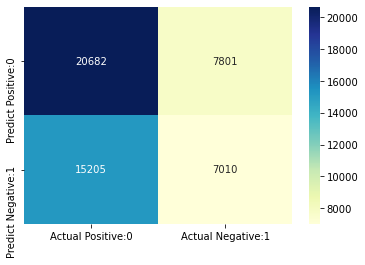

In [94]:
cm = confusion_matrix(y_test, y_pred)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
print('#####################################')
print(classification_report(y_test, y_pred))

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Benchmark DataFrame

In [95]:
X_backtest = df_combined.copy()
X_backtest = X_backtest.drop('close', axis=1)
if enable_val:
    X_backtest = X_backtest.loc[y_date_index_list[val_split]:]
else:
    X_backtest = X_backtest.loc[y_date_index_list[train_split]:]
X_backtest

accoci        assets     assetsavg       assetsc  \
date       ticker                                                           
2012-06-30 A      -3.500000e+07  9.757000e+09  9.331500e+09  4.211000e+09   
           AAPL    5.320000e+08  1.628960e+11  1.422205e+11  5.194300e+10   
           ABC    -4.325300e+07  1.574759e+10  1.558839e+10  1.117042e+10   
           ABT    -3.543531e+09  6.185979e+10  6.104516e+10  2.625749e+10   
           ACN    -5.965540e+08  1.553592e+10  1.559159e+10  1.145803e+10   
...                         ...           ...           ...           ...   
2021-09-30 YUM              NaN           NaN           NaN           NaN   
           ZBH              NaN           NaN           NaN           NaN   
           ZBRA             NaN           NaN           NaN           NaN   
           ZION             NaN           NaN           NaN           NaN   
           ZTS              NaN           NaN           NaN           NaN   

                       assetsnc  assetturnover    bvps         capex  \
date       ticker                                                      
2012-06-30 A       5.546000e+09          0.731  13.994 -4.900000e+07   
           AAPL    1.109530e+11          1.046   4.261 -2.963000e+09   
           ABC     4.577170e+09          5.171  11.621 -1.671680e+08   
           ABT     3.560230e+10          0.646  15.630 -4.251160e+08   
           ACN     4.077889e+09          1.903   6.358 -8.973300e+07   
...                         ...            ...     ...           ...   
2021-09-30 YUM              NaN            NaN     NaN           NaN   
           ZBH              NaN            NaN     NaN           NaN   
           ZBRA             NaN            NaN     NaN           NaN   
           ZION             NaN            NaN     NaN           NaN   
           ZTS              NaN            NaN     NaN           NaN   

                        cashneq    cashnequsd  ...  rolling_ros_3M  \
date       ticker                              ...                   
2012-06-30 A       1.923000e+09  1.923000e+09  ...       -0.033520   
           AAPL    7.945000e+09  7.945000e+09  ...        0.000000   
           ABC     1.655748e+09  1.655748e+09  ...        0.000000   
           ABT     1.100214e+10  1.100214e+10  ...       -0.465798   
           ACN     5.628659e+09  5.628659e+09  ...        0.016667   
...                         ...           ...  ...             ...   
2021-09-30 YUM              NaN           NaN  ...        0.000000   
           ZBH              NaN           NaN  ...        0.000000   
           ZBRA             NaN           NaN  ...        0.000000   
           ZION             NaN           NaN  ...        0.000000   
           ZTS              NaN           NaN  ...        0.000000   

                   rolling_ros_6M  rolling_ros_9M  rolling_ros_12M  \
date       ticker                                                    
2012-06-30 A             0.023669        0.023669         0.042169   
           AAPL          0.142405        0.142405         0.172078   
           ABC           0.000000        0.000000         0.000000   
           ABT           0.115646        0.131034        -0.006061   
           ACN           0.025210        0.025210              NaN   
...                           ...             ...              ...   
2021-09-30 YUM           0.021739        0.187726         0.146341   
           ZBH           0.440860      -15.888889        32.500000   
           ZBRA          0.068323        0.202797         0.246377   
           ZION          0.191601        0.604240         0.907563   
           ZTS           0.005780        0.041916         0.014577   

                   rolling_sbcomp_1M  rolling_sbcomp_2M  rolling_sbcomp_3M  \
date       ticker                                                            
2012-06-30 A               -0.774648          -0.774648          -0.774648   
           AAPL             0.

In [96]:
S = sec_master_raw.index.tolist()
probs = clf.predict_proba(X_backtest)
proba_df = pd.DataFrame(probs, columns=['0','1'], index=X_backtest.index)
proba_df = proba_df.drop('0', axis=1)
proba_df.rename(columns={'1':'probs'},inplace=True)

In [97]:
benchmark_weights = pd.DataFrame(index=X_backtest.index)
benchmark_weights = benchmark_weights.join(X['marketcap'].groupby(level=0).apply(lambda x: x/x.sum()), how='left')
benchmark_weights = benchmark_weights.fillna(0)
# benchmark_weights = benchmark_weights.unstack()
# benchmark_weights.columns = benchmark_weights.columns.map(''.join)
# benchmark_weights = benchmark_weights.stack()
# benchmark_weights = benchmark_weights[benchmark_weights!=0]

forward_1m_change = df_combined['close'].unstack().pct_change(1).shift(-1)
benchmark_df = pd.DataFrame(index=df_combined.index)
benchmark_df = benchmark_df.join(forward_1m_change.stack().to_frame('forward_rets'), how='left')
benchmark_df = benchmark_df.loc[:benchmark_df.index.get_level_values(0).unique()[-2]]

# Portfolio Optimisation

In [98]:
def optimisation_model(S,
                       proba_df,
                       benchmark_weights,
                       current_weights,
                       L_turnover,
                       L_security
                       ):
    
    M = ConcreteModel()
    M.w = Var(S, within=NonNegativeReals, bounds=(0,1), initialize=0)    
    M.Objective = Objective(
        expr=sum(proba_df[s]*M.w[s] for s in S),
        sense=maximize
    )
        
    @M.Constraint()
    def portfolio_sum_to_one(M):
        return(sum(M.w[s] for s in S)==1)
    
    @M.Constraint(S)
    def proper_weights(M, s):
        return(0, M.w[s], 1)
    
#     @M.Constraint()
#     def turnover_constraint(M):
#         return(-L_turnover, sum(M.w[s] - current_weights[s] for s in S), L_turnover)
    
    
    @M.Constraint(S)
    def active_security_bet(M, s):
        return(-L_security, M.w[s] - benchmark_weights[s], L_security)
    
    return M

In [148]:
solvername='glpk'
solverpath_folder='C:\\glpk\\w64' #does not need to be directly on c drive
solverpath_exe='C:\\glpk\\w64\\glpsol' #does not need to be directly on c drive

L_turnover = 0.5
L_security = 0.01

# proba_df = proba_df.unstack()
# proba_df = proba_df.reset_index()
# proba_df.columns = proba_df.columns.map(''.join)
# proba_df = proba_df.set_index('date')
# for col in proba_df.columns:
#     proba_df.rename(columns={col:col[1:]},inplace=True)

opt = SolverFactory(solvername,executable=solverpath_exe)

T_list = proba_df.index.get_level_values(0).unique().tolist()
df_limits_ref = pd.DataFrame(index=T_list)
df_portfolio_weights_before_rebalancing = pd.DataFrame().reindex_like(proba_df).fillna(0)
df_portfolio_weights_after_rebalancing = pd.DataFrame().reindex_like(proba_df).fillna(0)

df_limits_ref['L_turnover'] = L_turnover
df_limits_ref['L_security'] = L_security
df_limits_ref.loc[df_limits_ref.index[0], 'L_turnover'] = 999
df_portfolio_weights_before_rebalancing['weights'] = 0
df_portfolio_weights_after_rebalancing['weights'] = 0

df_portfolio_weights_before_rebalancing = df_portfolio_weights_before_rebalancing.drop('probs', axis=1)
df_portfolio_weights_after_rebalancing = df_portfolio_weights_after_rebalancing.drop('probs', axis=1)
df_portfolio_weights_before_rebalancing = df_portfolio_weights_before_rebalancing.unstack().shift(1).iloc[1:].stack()


print('Simulating for ', end='')
init=True
for t, t_next in windowed(T_list,2):
    state = True
    while state:
        print(f'{t}, ', end='')
        benchmark_weight_ref = benchmark_weights.loc[t, 'marketcap'].to_dict()
        proba_ref = proba_df.loc[t, 'probs'].fillna(-1).to_dict()
        S_ref = proba_df[proba_df>0].loc[t].index.to_list()
        
        if init:
            current_weight_ref = df_portfolio_weights_after_rebalancing.loc[t,'weights'].to_dict()
        else:
            current_weight_ref = df_portfolio_weights_before_rebalancing.loc[t,'weights'].to_dict()
            
        for key in benchmark_weight_ref.keys():
            if key not in current_weight_ref.keys():
                current_weight_ref[key] = 0
                
        L_turnover_ref = df_limits_ref.loc[t,'L_turnover']
        L_security_ref = df_limits_ref.loc[t,'L_security']

        M = optimisation_model(S_ref,
                               proba_ref,
                               benchmark_weight_ref,
                               current_weight_ref,
                               L_turnover_ref,
                               L_security_ref
                               )

        opt_results = opt.solve(M, tee=False)

        if (opt_results.solver.status == SolverStatus.ok) and (opt_results.solver.termination_condition == TerminationCondition.optimal):
            pass
        else:
            current_turnover = df_limits_ref.loc[t, 'L_turnover']
            df_limits_ref.loc[t, 'L_turnover'] += 0.05
            print(f'WARNING: Unable to find solution with L_turnover of {current_turnover}')
            continue
        
        df_weight_output_at_t = pd.DataFrame.from_dict(M.w.extract_values(), orient='index', columns=[str(M.w)])  
        
        if np.allclose(df_weight_output_at_t.min(axis=1), 0.0):
            df_weight_output_at_t[df_weight_output_at_t<0] = 0
        
        df_portfolio_weights_after_rebalancing.loc[t, :] = df_weight_output_at_t['w'].values
        
        if t_next is not None:
            drifted_weights = (benchmark_df.loc[t]+1).mul(df_weight_output_at_t['w'],axis=0)
            drifted_weights = drifted_weights/ drifted_weights.sum()
            df_portfolio_weights_before_rebalancing.loc[t_next, :] = drifted_weights['forward_rets'].values
        state = False
        init=False
print('Simulation complete')

Simulating for 2012-06-30 00:00:00, 2012-07-31 00:00:00, 2012-08-31 00:00:00, 2012-09-30 00:00:00, 2012-10-31 00:00:00, 2012-11-30 00:00:00, 2012-12-31 00:00:00, 2013-01-31 00:00:00, 2013-02-28 00:00:00, 2013-03-31 00:00:00, 2013-04-30 00:00:00, 2013-05-31 00:00:00, 2013-06-30 00:00:00, 2013-07-31 00:00:00, 2013-08-31 00:00:00, 2013-09-30 00:00:00, 2013-10-31 00:00:00, 2013-11-30 00:00:00, 2013-12-31 00:00:00, 2014-01-31 00:00:00, 2014-02-28 00:00:00, 2014-03-31 00:00:00, 2014-04-30 00:00:00, 2014-05-31 00:00:00, 2014-06-30 00:00:00, 2014-07-31 00:00:00, 2014-08-31 00:00:00, 2014-09-30 00:00:00, 2014-10-31 00:00:00, 2014-11-30 00:00:00, 2014-12-31 00:00:00, 2015-01-31 00:00:00, 2015-02-28 00:00:00, 2015-03-31 00:00:00, 2015-04-30 00:00:00, 2015-05-31 00:00:00, 2015-06-30 00:00:00, 2015-07-31 00:00:00, 2015-08-31 00:00:00, 2015-09-30 00:00:00, 2015-10-31 00:00:00, 2015-11-30 00:00:00, 2015-12-31 00:00:00, 2016-01-31 00:00:00, 2016-02-29 00:00:00, 2016-03-31 00:00:00, 2016-04-30 00:00:00

# Backtest

In [162]:
portfolio = df_portfolio_weights_after_rebalancing.copy()
portfolio = portfolio.join(benchmark_df, how='left')
wealth = (portfolio['weights']*portfolio['forward_rets'].values).groupby(level=0).sum()
wealth = wealth.shift(1)
start_date = wealth.index[0]
wealth.loc[start_date] = 0

compare_df = pd.DataFrame(index=wealth.index)
compare_df['portfolio'] = (wealth+1).cumprod()
benchmark_wealth = (spx['Close'].pct_change().loc[wealth.index])
benchmark_wealth.loc[start_date] = 0
compare_df['benchmark'] = (benchmark_wealth+1).cumprod()

final_X_test_date = X_test.index.get_level_values(0).unique()[-1]
fig = px.line(compare_df)
fig.add_vline(x=final_X_test_date, line_dash='dash')
fig.show()

In [150]:
#Number of stocks inv
px.line(df_portfolio_weights_after_rebalancing[df_portfolio_weights_after_rebalancing>0].dropna().groupby(level=0).count()).show()

# SHAP

In [151]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

C:\Users\Marcus\anaconda3\envs\quant\lib\site-packages\shap\explainers\_tree.py:349: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



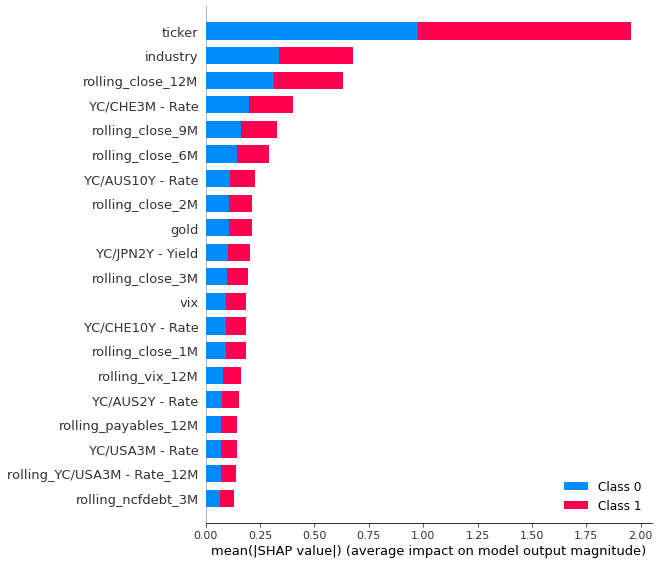

In [152]:
shap.summary_plot(shap_values, X)